In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import autograd as ad
import autograd.numpy as np
from cosmatrix import cosm

In [8]:
from autograd.extend import primitive, defvjp
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)

def g3g4(phi_ex,beta, N, Ej, Ec,omega_c):
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-3*np.cos((phi)/3))
#     phi_ex = 0.4*2*np.pi
    phi_min = sci.optimize.minimize(U_s,0).x
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    sixd = ad.grad(fived)
    sevend = ad.grad(sixd)
    eightd = ad.grad(sevend)
    c2 = secondd(phi_min[0])
    c3 = thirdd(phi_min[0])/3/2
    c4 = fourd(phi_min[0])/4/3/2
    c5 = fived(phi_min[0])/5/4/3/2
    c6 = sixd(phi_min[0])/6/5/4/3/2
    c7 = sevend(phi_min[0])/7/6/5/4/3/2
    c8 = eightd(phi_min[0])/8/7/6/5/4/3/2
    
    Ej = 90*2*np.pi
    Ec = 0.177*2*np.pi
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/Ej/c2,1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3
    g4 = Ej*phi_zpf**4*c4
    g_int =  0.1*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    delta = omega_c - omega_s
    
    return g3/2/np.pi,g4/2/np.pi,omega_s/2/np.pi,g_int/delta

def coupled_spectrum(phi_ex,beta,N,Ej,Ec,omega_c):
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs =( omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    
    cdim = 10
    c = annihilation(sdim)
    cd = creation(sdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int =  0.1*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    H_int = g_int*np.kron(s+sd,cd+c)
#     H_int = g_int*(np.kron(sd,c)+np.kron(s,cd))
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    return energy[1]/2/np.pi


def omega_cdress(phi_ex,beta,N,Ej,Ec,omega_c):
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    delta = omega_c - omega_s
    A = 0.1*2*np.pi*np.power((2*Ec)/Ej,1/4)
    phi_zpf = np.power(2*Ec/Ej/c2,1/4)
    g_int = A/phi_zpf
    return 1/2*(omega_s + omega_c - np.sqrt(delta**2 + 4*g_int**2))/2/np.pi


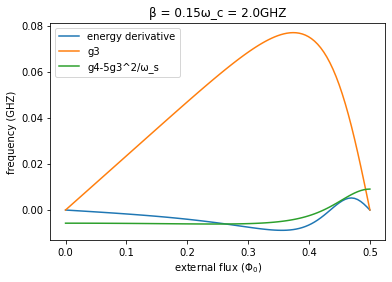

In [10]:
beta = 0.15
omega_c = 2*2*np.pi
N = 3
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
der = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
omegass = np.zeros(len(phi_exs))
god = np.zeros(len(phi_exs))
for i in range(len(phi_exs)):
    delta = 1e-3
    snail_energies[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec,omega_c)
    der[i] = grad(phi_exs[i],beta,N,Ej,Ec,omega_c)
    g3s[i],g4s[i],omegass[i],god[i] = g3g4(phi_exs[i],beta,N,Ej,Ec,omega_c)
plt.plot(phi_exs/2/np.pi,100*der,label = 'energy derivative')
plt.plot(phi_exs/2/np.pi,g3s, label = 'g3')
plt.plot(phi_exs/2/np.pi,g4s-5*g3s**2/omegass,label = 'g4-5g3^2/ω_s')
plt.xlabel('external flux ($\Phi_0$)')
plt.ylabel('frequency (GHZ)')
# plt.ylim(-0.02,0.09)
omega_c = float(omega_c/2/np.pi)
plt.title('β = '+str(beta)+'ω_c = '+str(omega_c)+'GHZ')
plt.legend()

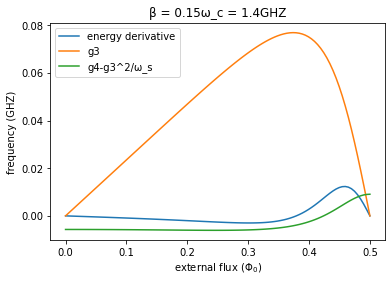

In [5]:
beta = 0.15
omega_c = 1.4*2*np.pi
N = 3
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
der = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
omegass = np.zeros(len(phi_exs))

for i in range(len(phi_exs)):
    delta = 1e-3
    snail_energies[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec,omega_c)
    der[i] = grad(phi_exs[i],beta,N,Ej,Ec,omega_c)
    g3s[i],g4s[i],omegass[i] = g3g4(phi_exs[i],beta,N,Ej,Ec,omega_c)
plt.plot(phi_exs/2/np.pi,100*der,label = 'energy derivative')
plt.plot(phi_exs/2/np.pi,g3s, label = 'g3')
plt.plot(phi_exs/2/np.pi,g4s-5*g3s**2/omegass,label = 'g4-g3^2/ω_s')
plt.xlabel('external flux ($\Phi_0$)')
plt.ylabel('frequency (GHZ)')
# plt.ylim(-0.02,0.09)
omega_c = float(omega_c/2/np.pi)
plt.title('β = '+str(beta)+'ω_c = '+str(omega_c)+'GHZ')
plt.legend()

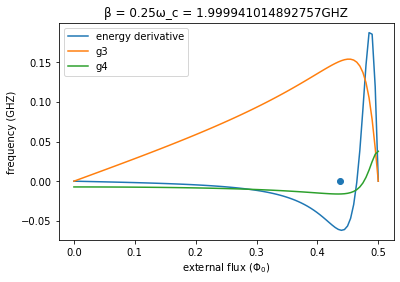

In [20]:
beta = 0.25
omega_c = 12.566
N = 3
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
der = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
omegass = np.zeros(len(phi_exs))
god = np.zeros(len(phi_exs))
for i in range(len(phi_exs)):
    snail_energies[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec,omega_c)
    der[i] = grad(phi_exs[i],beta,N,Ej,Ec,omega_c)
    g3s[i],g4s[i],omegass[i],god[i] = g3g4(phi_exs[i],beta,N,Ej,Ec,omega_c)
plt.plot(phi_exs/2/np.pi,100*der,label = 'energy derivative')
plt.plot(phi_exs/2/np.pi,g3s, label = 'g3')
plt.plot(phi_exs/2/np.pi,g4s-5*g3s**2/omegass,label = 'g4')
plt.scatter(2.7484/2/np.pi,0)
plt.xlabel('external flux ($\Phi_0$)')
plt.ylabel('frequency (GHZ)')
# plt.ylim(-0.02,0.09)
# plt.yscale('log')
omega_c = float(omega_c/2/np.pi)
plt.title('β = '+str(beta)+'ω_c = '+str(omega_c)+'GHZ')
plt.legend()

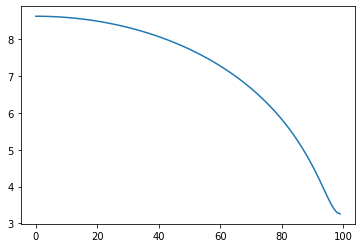

In [22]:
plt.plot(omegass)

In [423]:
beta = 0.17392149
omega_c = 12.566
N = 3
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
snail_energies = np.zeros(len(phi_exs))
der = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
omegass = np.zeros(len(phi_exs))
e0 = np.zeros(len(phi_exs))
e1 = np.zeros(len(phi_exs))
e2 = np.zeros(len(phi_exs))
e3 = np.zeros(len(phi_exs))
e4 = np.zeros(len(phi_exs))
e5 = np.zeros(len(phi_exs))
for i in range(len(phi_exs)):
    delta = 1e-3
    e0[i],e1[i],e2[i],e3[i],e4[i],e5[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec,omega_c)

# plt.plot(phi_exs/2/np.pi,100*der,label = 'energy derivative')
# plt.plot(phi_exs/2/np.pi,g3s, label = 'g3')
# plt.plot(phi_exs/2/np.pi,g4s-5*g3s**2/omegass,label = 'g4')
# plt.scatter(2.7484/2/np.pi,0)
# plt.xlabel('external flux ($\Phi_0$)')
# plt.ylabel('frequency (GHZ)')
# # plt.ylim(-0.02,0.09)
# # plt.yscale('log')
# omega_c = float(omega_c/2/np.pi)
# plt.title('β = '+str(beta)+'ω_c = '+str(omega_c)+'GHZ')
# plt.legend()

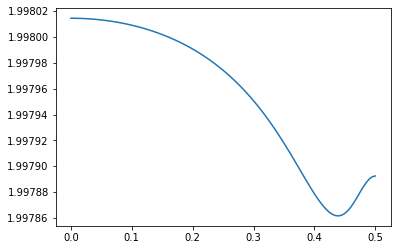

In [426]:
plt.plot(phi_exs/2/np.pi,e1,label = '1')

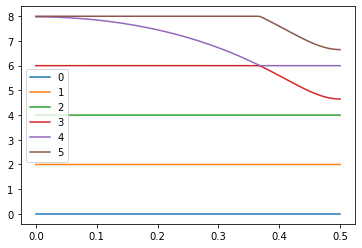

In [425]:
plt.plot(phi_exs/2/np.pi,e0,label = '0')
plt.plot(phi_exs/2/np.pi,e1,label = '1')
plt.plot(phi_exs/2/np.pi,e2,label = '2')
plt.plot(phi_exs/2/np.pi,e3,label = '3')
plt.plot(phi_exs/2/np.pi,e4,label = '4')
plt.plot(phi_exs/2/np.pi,e5,label = '5')
plt.legend()

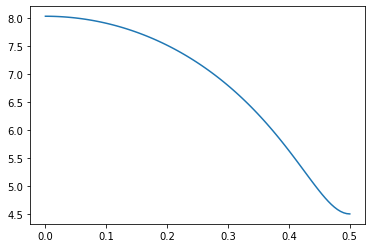

In [414]:
plt.plot(phi_exs/2/np.pi,omegass,label = 'ω_s')

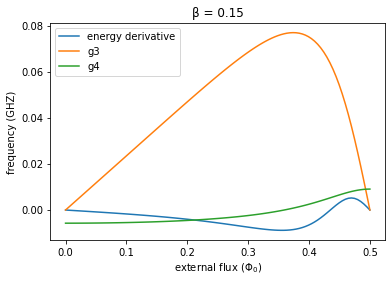

In [374]:
beta = 0.15
omega_c = 2*2*np.pi
N = 3
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
der = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
for i in range(len(phi_exs)):
    delta = 1e-3
    snail_energies[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec,omega_c)
    der[i] = grad(phi_exs[i],beta,N,Ej,Ec,omega_c)
    g3s[i],g4s[i] = g3g4(phi_exs[i],beta,N,Ej,Ec,omega_c)[0:2]
plt.plot(phi_exs/2/np.pi,100*der,label = 'energy derivative')
plt.plot(phi_exs/2/np.pi,g3s, label = 'g3')
plt.plot(phi_exs/2/np.pi,g4s,label = 'g4')
plt.xlabel('external flux ($\Phi_0$)')
plt.ylabel('frequency (GHZ)')
# plt.ylim(-0.02,0.09)
# plt.yscale('log')
plt.title('β = '+str(beta))
plt.legend()

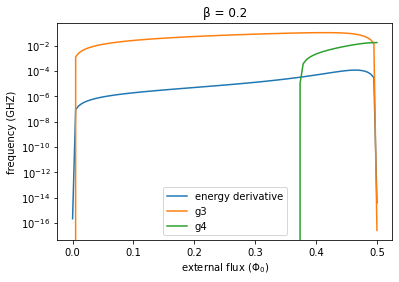

In [100]:
beta = 0.2
N = 3
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
der = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
for i in range(len(phi_exs)):
    delta = 1e-3
    snail_energies[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec)
    der[i] = grad(phi_exs[i],beta,N,Ej,Ec)
    g3s[i],g4s[i] = g3g4(phi_exs[i],beta,N,Ej,Ec)
plt.plot(phi_exs/2/np.pi,np.abs(der),label = 'energy derivative')
plt.plot(phi_exs/2/np.pi,g3s, label = 'g3')
plt.plot(phi_exs/2/np.pi,g4s,label = 'g4')
plt.xlabel('external flux ($\Phi_0$)')
plt.ylabel('frequency (GHZ)')
# plt.ylim(-0.02,0.09)
plt.yscale('log')
plt.title('β = '+str(beta))
plt.legend()

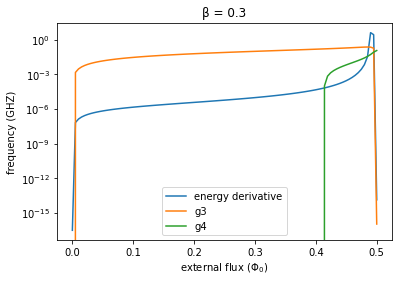

In [101]:
beta = 0.3
N = 3
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
der = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
for i in range(len(phi_exs)):
    delta = 1e-3
    snail_energies[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec)
    der[i] = grad(phi_exs[i],beta,N,Ej,Ec)
    g3s[i],g4s[i] = g3g4(phi_exs[i],beta,N,Ej,Ec)
plt.plot(phi_exs/2/np.pi,np.abs(der),label = 'energy derivative')
plt.plot(phi_exs/2/np.pi,g3s, label = 'g3')
plt.plot(phi_exs/2/np.pi,g4s,label = 'g4')
plt.xlabel('external flux ($\Phi_0$)')
plt.ylabel('frequency (GHZ)')
# plt.ylim(-0.02,0.09)
plt.yscale('log')
plt.title('β = '+str(beta))
plt.legend()